<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 342 kB 4.5 MB/s 


In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-07-14 02:10:26 INFO: Downloading default packages for language: es (Spanish)...


2022-07-14 02:12:18 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-07-14 02:12:18 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-07-14 02:12:18 INFO: Use device: cpu
2022-07-14 02:12:18 INFO: Loading: tokenize
2022-07-14 02:12:18 INFO: Loading: mwt
2022-07-14 02:12:18 INFO: Loading: pos
2022-07-14 02:12:18 INFO: Loading: lemma
2022-07-14 02:12:18 INFO: Loading: depparse
2022-07-14 02:12:19 INFO: Loading: ner
2022-07-14 02:12:21 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Reemplazar mayúsculas
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata
from spacy.lang.es.stop_words import STOP_WORDS

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # paso a minúsculas (igualmente spacy lo pasa a minúsculas también)
    text = text.lower()
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    
    return text 

### 3 - Diccionario de entrada

In [5]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es SpotiBot", "Yo soy SpotiBot"]
             },
            {"tag": "cliente_premium",
              "patterns": ["¿Cuáles son las ventajas?", "¿Es mejor ser cliente premium que cliente común?"],
              "responses": ["Claro que sí", "Si, podés escuchar música sin límites y sin anuncios"]
             },
            {"tag": "cliente_común",
              "patterns": ["¿Tengo costo por escuchar música siendo cliente común?", "¿Hay anuncios?"],
              "responses": ["No tenés costos pero hay anuncios", "Te aconsejo a pasarte a premium"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["En el siguiente <link> podrás encontrar los precios de los distintos paquetes"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "música",
              "patterns": ["¿Qué estilos hay disponibles?", "¿Hay rock?", "¿Hay folclore?"],
              "responses": ["Están todos los artistas de todos los estilos", "Lo que te imagines!!!"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset
- Eliminación de las *stop words*

In [6]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
          if not token.is_stop: # Elimino las stop_words           
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [7]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['anuncio', 'chau', 'cliente', 'comer', 'comun', 'costo', 'credito', 'cuota', 'disponible', 'escuchar', 'estilo', 'folclore', 'gracias', 'holar', 'medio', 'musica', 'nombre', 'pago', 'pasar', 'poder', 'precio', 'premium', 'rock', 'salir', 'ser', 'tarjeta', 'valer', 'ventaja']
classes: ['agradecimientos', 'bienvenida', 'cliente_común', 'cliente_premium', 'despedida', 'música', 'nombre', 'pagos', 'precios']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Cuáles son las ventajas?', '¿Es mejor ser cliente premium que cliente común?', '¿Tengo costo por escuchar música siendo cliente común?', '¿Hay anuncios?', 'precio', 'Me podrás pasar los precios', '¿Cuánto vale?', '¿Cuánto sale?', 'medios de pago', 'tarjeta de crédito', 'tarjetas', 'cuotas', '¿Qué estilos hay disponibles?', '¿Hay rock?', '¿Hay folclore?', 'Muchas gracias', 'Gracias', 'Chau', 'Hasta luego!']
doc_y: ['bienvenida', 'bienvenida', 'bienvenida', 'nombre', 'nombre', 'cliente_premium', 

In [8]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 28


In [9]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [10]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)
ohe = []
frec = []
out = []

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    i = 0
    frec_i = []
    frec_aux = np.zeros((len(text), len(words)))
    for word in text:
      frec_aux[i, np.argwhere(np.array(words) == word)] = 1
      i += 1
    frec_i = np.sum(frec_aux, axis = 0).tolist()

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    #print("X:", bow, "y:", output_row)
    training.append([bow, output_row])
    out.append(output_row)
    ohe.append(bow)
    frec.append(frec_i)

idf = np.log10((len(doc_X) * np.ones(len(words))) / np.sum(np.array(ohe), axis = 0))
tf_idf = np.array(frec) * idf

# Mezclar los datos
#random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_X_tf = tf_idf
train_y = np.array(list(training[:, 1]))

### 5 - Entrenamiento del modelo

In [11]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
input_shape_tf = (train_X_tf.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "input tfidf:", input_shape_tf, "output:", output_shape)

input: (28,) input tfidf: (28,) output: 9


In [14]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3712      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 12,553
Trainable params: 12,553
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 870ms/step - loss: 2.2093 - accuracy: 0.1667
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 2.1931 - accuracy: 0.1667
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 2.1829 - accuracy: 0.1250
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2022 - accuracy: 0.0417
Epoch 5/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2022 - accuracy: 0.0417
Epoch 6/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1929 - accuracy: 0.1250
Epoch 7/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1102 - accuracy: 0.1667
Epoch 8/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1287 - accuracy: 0.2917
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 2.1666 - accuracy: 0.2500
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1277 - accuracy: 0.2083
Epoch 11/200
1/1 [===

In [15]:
hist_tf = model.fit(x=train_X_tf, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 469ms/step - loss: 2.3724 - accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2697 - accuracy: 0.0833
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2586 - accuracy: 0.0833
Epoch 4/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2446 - accuracy: 0.0833
Epoch 5/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1841 - accuracy: 0.2500
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2270 - accuracy: 0.0833
Epoch 7/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2617 - accuracy: 0.2083
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1163 - accuracy: 0.2500
Epoch 9/200
1/1 [==============================] - 0s 16ms/step - loss: 2.1574 - accuracy: 0.1250
Epoch 10/200
1/1 [==============================] - 0s 15ms/step - loss: 2.2160 - accuracy: 0.0417
Epoch 11/200
1/1

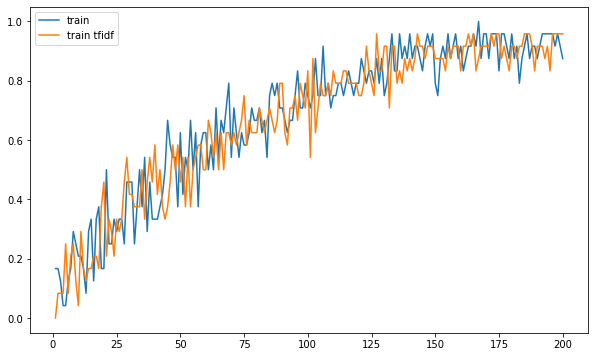

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
plt.figure(figsize = (10,6))
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist_tf.history['accuracy'], label='train tfidf')
plt.show()

In [17]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [18]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [19]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

hola
BOT: Hola!
quien eres
BOT: Yo soy SpotiBot
puedo ser cliente comun
BOT: No tenés costos pero hay anuncios
cual es la ventaja de premium
BOT: Si, podés escuchar música sin límites y sin anuncios
cuanto vale
BOT: En el siguiente <link> podrás encontrar los precios de los distintos paquetes
hay rock
BOT: Lo que te imagines!!!
gracias
BOT: Por nada!, cualquier otra consulta podes escribirme
vendes caramelos?
Perdón, no comprendo la pregunta.
chauuu
Perdón, no comprendo la pregunta.
chau
BOT: Hasta luego!

Perdón, no comprendo la pregunta.


KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot *SpotiBOT* es capaz de responder a diferentes tipos de preguntas con buena precisión. Adicionalmente al script brindado en la clase, se ensayaron las siguientes técnicas:
- Filtrado de los stop words
- Utilización TF-IDF

Se entrenó en modelo con BOW (ohe) y con TF-IDF. Los resultados son similares.